# Detección de Intrusiones en Red - UNSW-NB15

Clasificación multi-clase y detección de anomalías en flujos de tráfico de red.

Este notebook entrena y compara 4 modelos de Machine Learning para detectar diferentes tipos de ataques:

- **XGBoost** (supervisado)
- **Random Forest** (supervisado)
- **Isolation Forest** (no supervisado - detección de anomalías)
- **Autoencoder** (no supervisado - reconstrucción)

## Dataset: UNSW-NB15
Desarrollado por el Australian Centre for Cyber Security (ACCS) en 2015.

**Tipos de ataque:** Backdoor, Analysis, Fuzzers, Shellcode, Reconnaissance, Exploits, DoS, Worms, Generic

**Características:** 49 features extraídas del tráfico de red real y sintético.

In [44]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, IsolationForest
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# PyTorch para Autoencoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f"PyTorch version: {torch.__version__}")
print(f"Dispositivo: {'CUDA (GPU)' if torch.cuda.is_available() else 'CPU'}")
print("Librerías importadas correctamente")

PyTorch version: 2.9.0+cpu
Dispositivo: CPU
Librerías importadas correctamente


## 1. Configuración

In [45]:
# Selección de modelos a entrenar
USE_XGBOOST = True           # Gradient Boosting optimizado
USE_RANDOM_FOREST = True     # Ensemble de árboles de decisión
USE_ISOLATION_FOREST = True  # Detección de anomalías (no supervisado)
USE_AUTOENCODER = True       # Red neuronal para reconstrucción (no supervisado)

# Configuración de datos
TRAIN_SIZE = 350000  # Número de muestras para entrenamiento
TEST_SIZE = 350000   # Número de muestras para test
RANDOM_STATE = 42    # Semilla para reproducibilidad

print("="*80)
print("CONFIGURACIÓN DEL EXPERIMENTO")
print("="*80)
print(f"\nModelos activos:")
if USE_XGBOOST:
    print("  ✓ XGBoost (supervisado)")
if USE_RANDOM_FOREST:
    print("  ✓ Random Forest (supervisado)")
if USE_ISOLATION_FOREST:
    print("  ✓ Isolation Forest (no supervisado)")
if USE_AUTOENCODER:
    print("  ✓ Autoencoder (no supervisado)")

print(f"\nTamaño de datos:")
print(f"  - Entrenamiento: {TRAIN_SIZE:,} muestras")
print(f"  - Pruebas:       {TEST_SIZE:,} muestras")
print(f"  - Total:         {TRAIN_SIZE + TEST_SIZE:,} muestras")

if not any([USE_XGBOOST, USE_RANDOM_FOREST, USE_ISOLATION_FOREST, USE_AUTOENCODER]):
    print("\n  ADVERTENCIA: No hay modelos seleccionados")

CONFIGURACIÓN DEL EXPERIMENTO

Modelos activos:
  ✓ XGBoost (supervisado)
  ✓ Random Forest (supervisado)
  ✓ Isolation Forest (no supervisado)
  ✓ Autoencoder (no supervisado)

Tamaño de datos:
  - Entrenamiento: 350,000 muestras
  - Pruebas:       350,000 muestras
  - Total:         700,000 muestras


## 2. Carga de Datos

**Nota:** El dataset UNSW-NB15 no tiene cabecera. Definimos manualmente los nombres de las 49 columnas.

[1/4] Cargando dataset completo...

   Dataset cargado: 700,000 filas × 49 columnas

[2/4] Limpiando datos...

   Valores faltantes procesados

DISTRIBUCIÓN DE TIPOS DE ATAQUE
attack_cat
Normal            677785
Generic             7522
Exploits            5409
 Fuzzers            5051
Reconnaissance      1759
DoS                 1167
Backdoors            534
Analysis             526
Shellcode            223
Worms                 24
Name: count, dtype: int64

Total: 700,000 flujos
   Dataset cargado: 700,000 filas × 49 columnas

[2/4] Limpiando datos...

   Valores faltantes procesados

DISTRIBUCIÓN DE TIPOS DE ATAQUE
attack_cat
Normal            677785
Generic             7522
Exploits            5409
 Fuzzers            5051
Reconnaissance      1759
DoS                 1167
Backdoors            534
Analysis             526
Shellcode            223
Worms                 24
Name: count, dtype: int64

Total: 700,000 flujos


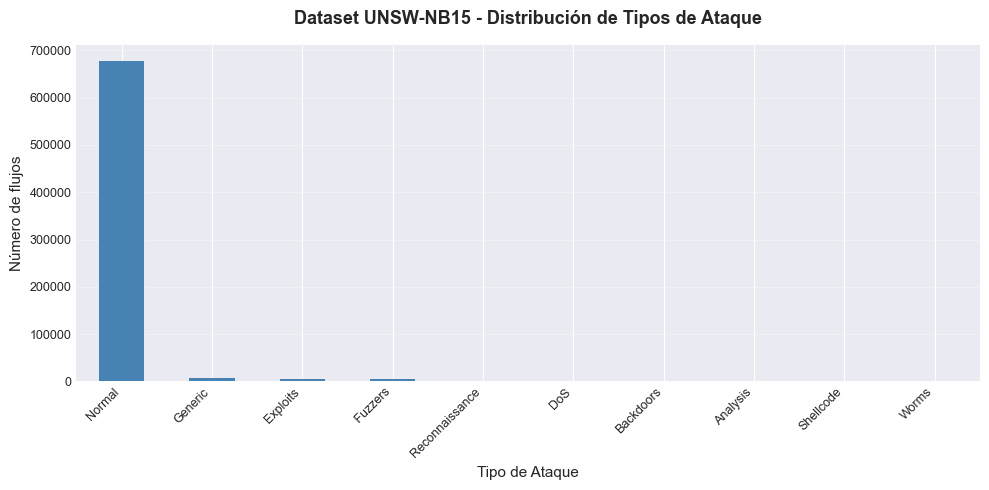


[3/4] Dividiendo datos (train 50% / test 50%)...

   Train: 350,000 muestras (50.0%)
   Test:  350,000 muestras (50.0%)

[4/4] Verificando distribución en train/test...

Distribución en TRAIN:
attack_cat
Normal            338892
Generic             3761
Exploits            2704
 Fuzzers            2525
Reconnaissance       880
DoS                  584
Backdoors            267
Analysis             263
Shellcode            112
Worms                 12
Name: count, dtype: int64

Distribución en TEST:
attack_cat
Normal            338893
Generic             3761
Exploits            2705
 Fuzzers            2526
Reconnaissance       879
DoS                  583
Backdoors            267
Analysis             263
Shellcode            111
Worms                 12
Name: count, dtype: int64
   Train: 350,000 muestras (50.0%)
   Test:  350,000 muestras (50.0%)

[4/4] Verificando distribución en train/test...

Distribución en TRAIN:
attack_cat
Normal            338892
Generic             3761
Explo

In [46]:
# Definición de las 49 columnas del dataset UNSW-NB15
unsw_columns = [
    'srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes',
    'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload', 'spkts', 'dpkts',
    'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth',
    'res_bdy_len', 'sjit', 'djit', 'stime', 'ltime', 'sintpkt', 'dintpkt',
    'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd',
    'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm',
    'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
    'attack_cat', 'label'
]

print("[1/4] Cargando dataset completo...\n")
df_full = pd.read_csv('UNSW-NB15_1.csv', header=None, names=unsw_columns, 
                      nrows=TRAIN_SIZE + TEST_SIZE)

print(f"   Dataset cargado: {df_full.shape[0]:,} filas × {df_full.shape[1]} columnas")

print("\n[2/4] Limpiando datos...\n")
# Rellenar valores faltantes
df_full['attack_cat'] = df_full['attack_cat'].fillna('Normal')  # Categoría de ataque
df_full['label'] = df_full['label'].fillna(0).astype(int)       # Label binaria (0=normal, 1=ataque)
print("   Valores faltantes procesados")

print("\n" + "="*80)
print("DISTRIBUCIÓN DE TIPOS DE ATAQUE")
print("="*80)
attack_counts = df_full['attack_cat'].value_counts()
print(attack_counts)
print(f"\nTotal: {len(df_full):,} flujos")

# Visualización de distribución
plt.figure(figsize=(10, 5))
attack_counts.plot(kind='bar', color='steelblue')
plt.title('Dataset UNSW-NB15 - Distribución de Tipos de Ataque', 
          fontsize=13, fontweight='bold', pad=15)
plt.xlabel('Tipo de Ataque', fontsize=20)
plt.ylabel('Número de flujos', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n[3/4] Dividiendo datos (train 50% / test 50%)...\n")
# Split con estratificación para mantener proporciones de ataques
df_train, df_test = train_test_split(
    df_full, 
    test_size=0.5, 
    random_state=RANDOM_STATE,
    stratify=df_full['attack_cat']  # Mantener distribución de ataques
)

print(f"   Train: {df_train.shape[0]:,} muestras ({df_train.shape[0]/len(df_full)*100:.1f}%)")
print(f"   Test:  {df_test.shape[0]:,} muestras ({df_test.shape[0]/len(df_full)*100:.1f}%)")

print("\n[4/4] Verificando distribución en train/test...\n")
print("Distribución en TRAIN:")
print(df_train['attack_cat'].value_counts())
print("\nDistribución en TEST:")
print(df_test['attack_cat'].value_counts())

## 3. Preprocesamiento de Datos

In [47]:
def preprocess_data(df):
    """
    Preprocesa el dataset UNSW-NB15:
    - Elimina columnas no predictivas (IPs, timestamps)
    - Codifica variables categóricas
    - Convierte todo a numérico
    - Rellena valores faltantes e infinitos
    """
    df = df.copy()
    
    # Eliminar columnas no predictivas (identificadores, timestamps)
    drop_cols = ['srcip', 'dstip', 'stime', 'ltime']
    df = df.drop(columns=drop_cols, errors='ignore')
    print(f"   Columnas eliminadas: {drop_cols}")
    
    # Identificar columnas categóricas para codificar
    categorical_cols = ['proto', 'state', 'service']
    
    # Convertir columnas numéricas (reemplazar no-numéricos con NaN, luego rellenar con 0)
    numeric_cols = [col for col in df.columns if col not in categorical_cols + ['attack_cat', 'label']]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    print(f"   Columnas numéricas procesadas: {len(numeric_cols)}")
    
    # Codificar características categóricas (proto, state, service)
    for col in categorical_cols:
        if col in df.columns:
            df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    print(f"   Columnas categóricas codificadas: {categorical_cols}")
    
    # Manejar valores faltantes (NaN → 0)
    df = df.fillna(0)
    
    # Reemplazar valores infinitos (inf → 0)
    df = df.replace([np.inf, -np.inf], 0)
    print("   Valores faltantes e infinitos reemplazados con 0")
    
    return df

print("Preprocesando datos...\n")
df_train_processed = preprocess_data(df_train)
df_test_processed = preprocess_data(df_test)

print(f"\n✓ Train procesado: {df_train_processed.shape}")
print(f"✓ Test procesado:  {df_test_processed.shape}")

Preprocesando datos...

   Columnas eliminadas: ['srcip', 'dstip', 'stime', 'ltime']
   Columnas numéricas procesadas: 40
   Columnas categóricas codificadas: ['proto', 'state', 'service']
   Columnas numéricas procesadas: 40
   Columnas categóricas codificadas: ['proto', 'state', 'service']
   Valores faltantes e infinitos reemplazados con 0
   Columnas eliminadas: ['srcip', 'dstip', 'stime', 'ltime']
   Valores faltantes e infinitos reemplazados con 0
   Columnas eliminadas: ['srcip', 'dstip', 'stime', 'ltime']
   Columnas numéricas procesadas: 40
   Columnas categóricas codificadas: ['proto', 'state', 'service']
   Columnas numéricas procesadas: 40
   Columnas categóricas codificadas: ['proto', 'state', 'service']
   Valores faltantes e infinitos reemplazados con 0

✓ Train procesado: (350000, 45)
✓ Test procesado:  (350000, 45)
   Valores faltantes e infinitos reemplazados con 0

✓ Train procesado: (350000, 45)
✓ Test procesado:  (350000, 45)


In [48]:
# Separar características (X) y etiquetas (y)
X_train = df_train_processed.drop(columns=['attack_cat', 'label'])
y_train_binary = df_train_processed['label']  # 0=Normal, 1=Ataque
y_train_multiclass = df_train_processed['attack_cat']  # Tipo específico de ataque

X_test = df_test_processed.drop(columns=['attack_cat', 'label'])
y_test_binary = df_test_processed['label']
y_test_multiclass = df_test_processed['attack_cat']

# Codificar etiquetas multi-clase a números
le = LabelEncoder()
y_train_multi_encoded = le.fit_transform(y_train_multiclass.astype(str))
y_test_multi_encoded = le.transform(y_test_multiclass.astype(str))

print(f"Features (características): {X_train.shape[1]}")
print(f"Clases: {len(le.classes_)}")
print(f"Nombres de clases: {list(le.classes_)}")

Features (características): 43
Clases: 10
Nombres de clases: [' Fuzzers', 'Analysis', 'Backdoors', 'DoS', 'Exploits', 'Generic', 'Normal', 'Reconnaissance', 'Shellcode', 'Worms']


In [49]:
# Escalado de características (normalización)
# Necesario para Regresión Logística y Autoencoder
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Datos de entrenamiento escalados: {X_train_scaled.shape}")
print(f"Datos de prueba escalados: {X_test_scaled.shape}")
print("✓ Normalización completada (media=0, std=1)")

Datos de entrenamiento escalados: (350000, 43)
Datos de prueba escalados: (350000, 43)
✓ Normalización completada (media=0, std=1)


## 4. Entrenamiento de Modelos

### XGBoost

In [50]:
if USE_XGBOOST:
    print("Entrenando XGBoost (clasificación multi-clase)...\n")
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,      # Número de árboles
        max_depth=6,           # Profundidad máxima
        learning_rate=0.1,     # Tasa de aprendizaje
        random_state=RANDOM_STATE,
        n_jobs=-1              # Usar todos los cores
    )
    xgb_model.fit(X_train_scaled, y_train_multi_encoded)
    print("✓ XGBoost entrenado correctamente")
else:
    xgb_model = None
    print("⊗ XGBoost omitido (desactivado)")

Entrenando XGBoost (clasificación multi-clase)...

✓ XGBoost entrenado correctamente
✓ XGBoost entrenado correctamente


### Random Forest

In [51]:
if USE_RANDOM_FOREST:
    print("Entrenando Random Forest (clasificación multi-clase)...\n")
    rf_model = RandomForestClassifier(
        n_estimators=100,      # Número de árboles
        max_depth=20,          # Profundidad máxima
        random_state=RANDOM_STATE,
        n_jobs=-1              # Usar todos los cores
    )
    rf_model.fit(X_train_scaled, y_train_multi_encoded)
    print("✓ Random Forest entrenado correctamente")
else:
    rf_model = None
    print("⊗ Random Forest omitido (desactivado)")

Entrenando Random Forest (clasificación multi-clase)...

✓ Random Forest entrenado correctamente
✓ Random Forest entrenado correctamente


### Isolation Forest (No Supervisado)

In [52]:
if USE_ISOLATION_FOREST:
    print("Entrenando Isolation Forest (detección de anomalías)...\n")
    iso_model = IsolationForest(
        n_estimators=100,      # Número de árboles
        contamination=0.1,     # % esperado de anomalías (10%)
        random_state=RANDOM_STATE,
        n_jobs=-1              # Usar todos los cores
    )
    # Isolation Forest NO usa las etiquetas (no supervisado)
    iso_model.fit(X_train_scaled)
    print("✓ Isolation Forest entrenado correctamente")
else:
    iso_model = None
    print("⊗ Isolation Forest omitido (desactivado)")

Entrenando Isolation Forest (detección de anomalías)...

✓ Isolation Forest entrenado correctamente
✓ Isolation Forest entrenado correctamente


### Autoencoder (Red Neuronal - No Supervisado)

In [53]:
if USE_AUTOENCODER:
    # Definir arquitectura del Autoencoder
    class Autoencoder(nn.Module):
        """
        Autoencoder: red neuronal que aprende a reconstruir datos normales.
        - Encoder: comprime los datos de input_dim → 32 → 16 → 8 (representación latente)
        - Decoder: reconstruye desde 8 → 16 → 32 → input_dim
        
        Si un dato es anómalo, el error de reconstrucción será alto.
        """
        def __init__(self, input_dim):
            super(Autoencoder, self).__init__()
            # Encoder: comprime la información
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, 32),
                nn.ReLU(),
                nn.Linear(32, 16),
                nn.ReLU(),
                nn.Linear(16, 8),
                nn.ReLU()
            )
            # Decoder: reconstruye la información
            self.decoder = nn.Sequential(
                nn.Linear(8, 16),
                nn.ReLU(),
                nn.Linear(16, 32),
                nn.ReLU(),
                nn.Linear(32, input_dim)
            )
        
        def forward(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded
    
    print("Entrenando Autoencoder (reconstrucción - no supervisado)...\n")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"   Dispositivo: {device}")
    
    # Entrenar SOLO con tráfico normal (aprende a reconstruir lo "normal")
    X_train_normal = X_train_scaled[y_train_binary == 0]
    print(f"   Muestras normales para entrenamiento: {len(X_train_normal):,}")
    
    # Crear modelo
    autoencoder = Autoencoder(X_train_scaled.shape[1]).to(device)
    criterion = nn.MSELoss()  # Error cuadrático medio
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    
    # Preparar datos
    train_dataset = TensorDataset(torch.FloatTensor(X_train_normal))
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    
    # Entrenar
    epochs = 10
    print(f"   Epochs: {epochs}\n")
    for epoch in range(epochs):
        autoencoder.train()
        total_loss = 0
        for batch in train_loader:
            data = batch[0].to(device)
            optimizer.zero_grad()
            output = autoencoder(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if (epoch + 1) % 2 == 0:
            avg_loss = total_loss/len(train_loader)
            print(f"   Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
    
    print("\n✓ Autoencoder entrenado correctamente")
else:
    autoencoder = None
    device = None
    print("⊗ Autoencoder omitido (desactivado)")

Entrenando Autoencoder (reconstrucción - no supervisado)...

   Dispositivo: cpu
   Muestras normales para entrenamiento: 338,892
   Epochs: 10

   Epoch 2/10 - Loss: 0.1853
   Epoch 2/10 - Loss: 0.1853
   Epoch 4/10 - Loss: 0.1248
   Epoch 4/10 - Loss: 0.1248
   Epoch 6/10 - Loss: 0.1029
   Epoch 6/10 - Loss: 0.1029
   Epoch 8/10 - Loss: 0.0931
   Epoch 8/10 - Loss: 0.0931
   Epoch 10/10 - Loss: 0.0813

✓ Autoencoder entrenado correctamente
   Epoch 10/10 - Loss: 0.0813

✓ Autoencoder entrenado correctamente


## 5. Evaluación de Modelos

### Predicciones en el Conjunto de Test

In [54]:
# Diccionario para almacenar resultados de todos los modelos
results = {}

print("Generando predicciones en el conjunto de test...\n")

# Modelos supervisados (multi-clase)
if USE_XGBOOST:
    print("  → XGBoost...")
    xgb_pred = xgb_model.predict(X_test_scaled)
    results['XGBoost'] = {
        'predictions': xgb_pred,
        'type': 'multiclass'
    }

if USE_RANDOM_FOREST:
    print("  → Random Forest...")
    rf_pred = rf_model.predict(X_test_scaled)
    results['Random Forest'] = {
        'predictions': rf_pred,
        'type': 'multiclass'
    }

# Modelos no supervisados (binario: normal/ataque)
if USE_ISOLATION_FOREST:
    print("  → Isolation Forest...")
    iso_pred = iso_model.predict(X_test_scaled)
    # Isolation Forest devuelve: 1=normal, -1=anomalía
    # Convertir a: 0=normal, 1=ataque
    iso_pred_binary = (iso_pred == -1).astype(int)
    results['Isolation Forest'] = {
        'predictions': iso_pred_binary,
        'type': 'binary'
    }

if USE_AUTOENCODER:
    print("  → Autoencoder...")
    autoencoder.eval()  # Modo evaluación (sin dropout, etc.)
    with torch.no_grad():  # No calcular gradientes
        X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
        reconstructed = autoencoder(X_test_tensor)
        # Calcular error de reconstrucción (MSE por muestra)
        mse = torch.mean((X_test_tensor - reconstructed) ** 2, dim=1).cpu().numpy()
    
    # Umbral: percentil 90 de los errores (10% con mayor error = anomalías)
    threshold = np.percentile(mse, 90)
    ae_pred_binary = (mse > threshold).astype(int)
    results['Autoencoder'] = {
        'predictions': ae_pred_binary,
        'scores': mse,
        'threshold': threshold,
        'type': 'binary'
    }

print(f"\n✓ Predicciones generadas para {len(results)} modelo(s)")

Generando predicciones en el conjunto de test...

  → XGBoost...
  → Random Forest...
  → Random Forest...
  → Isolation Forest...
  → Isolation Forest...
  → Autoencoder...

✓ Predicciones generadas para 4 modelo(s)
  → Autoencoder...

✓ Predicciones generadas para 4 modelo(s)


### Métricas de Rendimiento

In [55]:
print("=" * 80)
print("RESULTADOS DE EVALUACIÓN")
print("=" * 80)

for model_name, model_data in results.items():
    print(f"\n{model_name}:")
    print("-" * 80)
    
    if model_data['type'] == 'multiclass':
        # Modelos supervisados multi-clase
        y_true = y_test_multi_encoded
        y_pred = model_data['predictions']
        
        accuracy = accuracy_score(y_true, y_pred)
        print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"\nReporte de Clasificación:")
        print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))
    
    elif model_data['type'] == 'binary':
        # Modelos no supervisados binarios
        y_true = y_test_binary
        y_pred = model_data['predictions']
        
        # Calcular matriz de confusión
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
        
        # Calcular tasas de error
        total_normal = tn + fp
        total_attack = fn + tp
        fp_rate = (fp / total_normal * 100) if total_normal > 0 else 0
        fn_rate = (fn / total_attack * 100) if total_attack > 0 else 0
        
        # Métricas estándar
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
        
        print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
        print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
        print(f"F1-Score:  {f1:.4f}")
        
        # Matriz de confusión detallada
        print(f"\nMatriz de Confusión:")
        print(f"  TN (Normal correctamente clasificado):  {tn:6,}")
        print(f"  FP (Normal clasificado como Ataque):    {fp:6,} → {fp_rate:5.2f}% del tráfico normal")
        print(f"  FN (Ataque clasificado como Normal):    {fn:6,} → {fn_rate:5.2f}% de ataques NO detectados")
        print(f"  TP (Ataque correctamente clasificado):  {tp:6,}")
        
        if 'threshold' in model_data:
            print(f"\nUmbral de decisión: {model_data['threshold']:.4f}")

print("\n" + "=" * 80)

RESULTADOS DE EVALUACIÓN

XGBoost:
--------------------------------------------------------------------------------
Accuracy: 0.9913 (99.13%)

Reporte de Clasificación:
                precision    recall  f1-score   support

       Fuzzers       0.67      0.66      0.67      2526
      Analysis       1.00      0.00      0.01       263
     Backdoors       0.33      0.00      0.01       267
           DoS       0.44      0.14      0.21       583
      Exploits       0.62      0.87      0.72      2705
       Generic       0.98      0.96      0.97      3761
        Normal       1.00      1.00      1.00    338893
Reconnaissance       0.95      0.87      0.91       879
     Shellcode       0.75      0.88      0.81       111
         Worms       0.33      0.08      0.13        12

      accuracy                           0.99    350000
     macro avg       0.71      0.55      0.54    350000
  weighted avg       0.99      0.99      0.99    350000


Random Forest:
----------------------------

### Matrices de Confusión

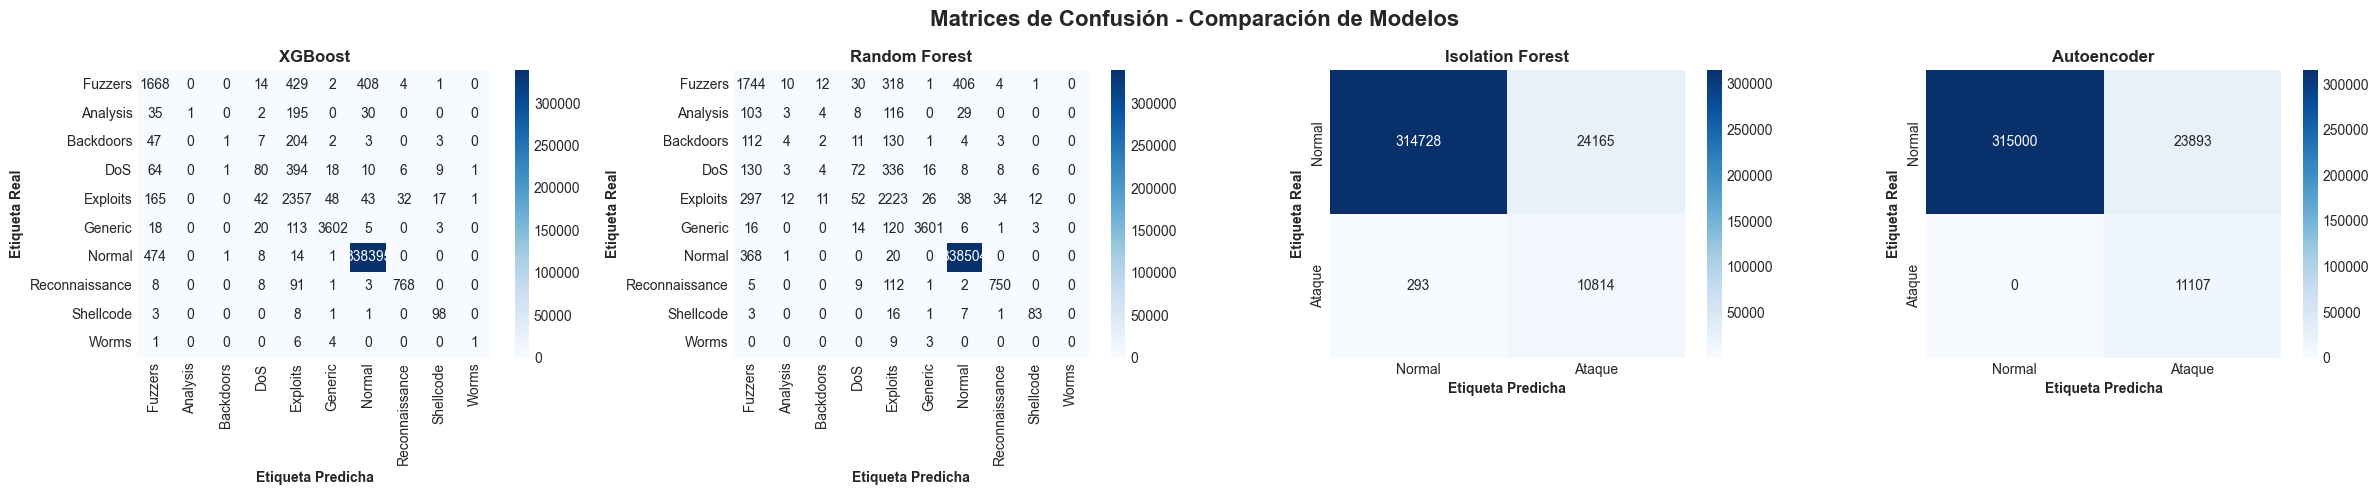

In [56]:
n_models = len(results)
if n_models > 0:
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    if n_models == 1:
        axes = [axes]
    
    fig.suptitle('Matrices de Confusión - Comparación de Modelos', 
                 fontsize=16, fontweight='bold')
    
    for idx, (model_name, model_data) in enumerate(results.items()):
        if model_data['type'] == 'multiclass':
            cm = confusion_matrix(y_test_multi_encoded, model_data['predictions'])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                       xticklabels=le.classes_, yticklabels=le.classes_)
        else:
            cm = confusion_matrix(y_test_binary, model_data['predictions'])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                       xticklabels=['Normal', 'Ataque'], yticklabels=['Normal', 'Ataque'])
        
        axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Etiqueta Real', fontweight='bold')
        axes[idx].set_xlabel('Etiqueta Predicha', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No hay modelos para visualizar")

### Análisis Detallado de Errores (Modelos Binarios)


ANÁLISIS DETALLADO DE ERRORES (MODELOS DE DETECCIÓN DE ANOMALÍAS)

 FALSOS POSITIVOS (FP) - Tráfico normal marcado como ataque
   (Molesto pero NO crítico - genera alertas innecesarias)

   Isolation Forest    : 24,165 FP ( 7.13% del tráfico normal)
   Autoencoder         : 23,893 FP ( 7.05% del tráfico normal)

 FALSOS NEGATIVOS (FN) - Ataques NO detectados
   (CRÍTICO para seguridad - ataques que pasan desapercibidos)

   Isolation Forest    :   293 FN ( 2.64% de ataques NO detectados)
   Autoencoder         :     0 FN ( 0.00% de ataques NO detectados)

✓ MEJOR MODELO (menor tasa de FN): Autoencoder
   Recall: 1.0000 (100.00% de ataques detectados)
   Falsos Negativos: 0 (0.00%)



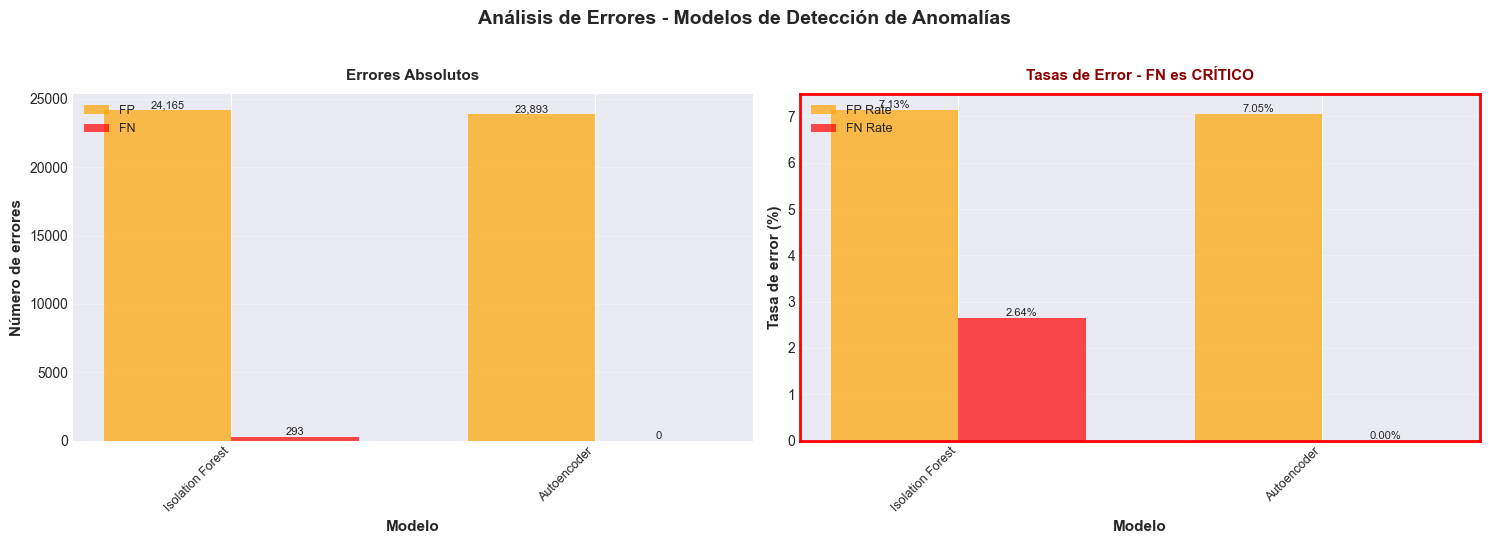

In [ ]:
# Filtrar modelos binarios (no supervisados)
binary_models = {k: v for k, v in results.items() if v['type'] == 'binary'}

if binary_models:
    print("\n" + "=" * 80)
    print("ANÁLISIS DETALLADO DE ERRORES (MODELOS DE DETECCIÓN DE ANOMALÍAS)")
    print("=" * 80)

    print("\n FALSOS POSITIVOS (FP) - Tráfico normal marcado como ataque")
    print("   (Molesto pero NO crítico - genera alertas innecesarias)\n")

    for model_name, model_data in binary_models.items():
        y_pred = model_data['predictions']
        cm = confusion_matrix(y_test_binary, y_pred)
        tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
        
        total_normal = tn + fp
        fp_rate = (fp / total_normal * 100) if total_normal > 0 else 0
        print(f"   {model_name:20s}: {fp:5,} FP ({fp_rate:5.2f}% del tráfico normal)")

    print("\n FALSOS NEGATIVOS (FN) - Ataques NO detectados")
    print("   (CRÍTICO para seguridad - ataques que pasan desapercibidos)\n")

    for model_name, model_data in binary_models.items():
        y_pred = model_data['predictions']
        cm = confusion_matrix(y_test_binary, y_pred)
        tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
        
        total_attack = fn + tp
        fn_rate = (fn / total_attack * 100) if total_attack > 0 else 0
        print(f"   {model_name:20s}: {fn:5,} FN ({fn_rate:5.2f}% de ataques NO detectados)")

    # Mejor modelo por recall (menos FN)
    if binary_models:
        best_model = min(binary_models.items(), 
                        key=lambda x: confusion_matrix(y_test_binary, x[1]['predictions'])[1, 0])
        cm = confusion_matrix(y_test_binary, best_model[1]['predictions'])
        fn = cm[1, 0]
        fn_rate = (fn / (cm[1, 0] + cm[1, 1]) * 100)
        recall = 1 - (fn_rate / 100)
        
        print(f"\n✓ MEJOR MODELO (menor tasa de FN): {best_model[0]}")
        print(f"   Recall: {recall:.4f} ({recall*100:.2f}% de ataques detectados)")
        print(f"   Falsos Negativos: {fn:,} ({fn_rate:.2f}%)")

    print("\n" + "=" * 80)
    
    # Visualización de errores
    if len(binary_models) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5.5))
        fig.suptitle('Análisis de Errores - Modelos de Detección de Anomalías', 
                     fontsize=14, fontweight='bold', y=0.98)

        model_names = list(binary_models.keys())
        fp_values = []
        fn_values = []
        fp_rates = []
        fn_rates = []

        for model_name, model_data in binary_models.items():
            cm = confusion_matrix(y_test_binary, model_data['predictions'])
            tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
            
            total_normal = tn + fp
            total_attack = fn + tp
            
            fp_values.append(fp)
            fn_values.append(fn)
            fp_rates.append((fp / total_normal * 100) if total_normal > 0 else 0)
            fn_rates.append((fn / total_attack * 100) if total_attack > 0 else 0)

        x = np.arange(len(model_names))
        width = 0.35

        # Gráfico 1: Errores absolutos
        bars1 = axes[0].bar(x - width/2, fp_values, width, label='FP', 
                            color='orange', alpha=0.7)
        bars2 = axes[0].bar(x + width/2, fn_values, width, label='FN', 
                            color='red', alpha=0.7)

        axes[0].set_xlabel('Modelo', fontweight='bold', fontsize=20)
        axes[0].set_ylabel('Número de errores', fontweight='bold', fontsize=20)
        axes[0].set_title('Errores Absolutos', fontweight='bold', fontsize=20, pad=10)
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(model_names, rotation=45, ha='right', fontsize=9)
        axes[0].legend(loc='upper left', fontsize=9)
        axes[0].grid(axis='y', alpha=0.3)

        # Añadir valores
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                axes[0].text(bar.get_x() + bar.get_width()/2., height,
                            f'{int(height):,}', ha='center', va='bottom', fontsize=8)

        # Gráfico 2: Tasas de error
        bars3 = axes[1].bar(x - width/2, fp_rates, width, label='FP Rate', 
                            color='orange', alpha=0.7)
        bars4 = axes[1].bar(x + width/2, fn_rates, width, label='FN Rate', 
                            color='red', alpha=0.7)

        axes[1].set_xlabel('Modelo', fontweight='bold', fontsize=20)
        axes[1].set_ylabel('Tasa de error (%)', fontweight='bold', fontsize=20)
        axes[1].set_title('Tasas de Error - FN es CRÍTICO', fontweight='bold', 
                         color='darkred', fontsize=20, pad=10)
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(model_names, rotation=45, ha='right', fontsize=9)
        axes[1].legend(loc='upper left', fontsize=9)
        axes[1].grid(axis='y', alpha=0.3)

        # Añadir valores
        for bars in [bars3, bars4]:
            for bar in bars:
                height = bar.get_height()
                axes[1].text(bar.get_x() + bar.get_width()/2., height,
                            f'{height:.2f}%', ha='center', va='bottom', fontsize=8)

        # Resaltar gráfico de tasas con borde rojo
        for spine in axes[1].spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(2)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
else:
    print("\nNo hay modelos binarios (de anomalías) para analizar errores")

### Detección por Tipo de Ataque (Modelos Supervisados)

In [65]:
# Filtrar solo modelos supervisados multi-clase
supervised_models = {k: v for k, v in results.items() if v['type'] == 'multiclass'}

if supervised_models:
    print("=" * 80)
    print("DETECCIÓN POR TIPO DE ATAQUE (MODELOS SUPERVISADOS)")
    print("=" * 80)
    
    for model_name, model_data in supervised_models.items():
        print(f"\n{model_name}:")
        print("-" * 80)
        
        # Analizar precisión por cada tipo de ataque
        for i, attack_class in enumerate(le.classes_):
            mask = y_test_multi_encoded == i
            if mask.sum() > 0:
                correct = (model_data['predictions'][mask] == i).sum()
                total = mask.sum()
                accuracy = correct / total
                print(f"  {attack_class:20s}: {correct:6d}/{total:6d} detected ({accuracy:6.2%})")
    
    print("\n" + "=" * 80)
else:
    print("No hay modelos supervisados activos")

DETECCIÓN POR TIPO DE ATAQUE (MODELOS SUPERVISADOS)

XGBoost:
--------------------------------------------------------------------------------
   Fuzzers            :   1668/  2526 detected (66.03%)
  Analysis            :      1/   263 detected ( 0.38%)
  Backdoors           :      1/   267 detected ( 0.37%)
  DoS                 :     80/   583 detected (13.72%)
  Exploits            :   2357/  2705 detected (87.13%)
  Generic             :   3602/  3761 detected (95.77%)
  Normal              : 338395/338893 detected (99.85%)
  Reconnaissance      :    768/   879 detected (87.37%)
  Shellcode           :     98/   111 detected (88.29%)
  Worms               :      1/    12 detected ( 8.33%)

Random Forest:
--------------------------------------------------------------------------------
   Fuzzers            :   1744/  2526 detected (69.04%)
  Analysis            :      3/   263 detected ( 1.14%)
  Backdoors           :      2/   267 detected ( 0.75%)
  DoS                 :     72/ 

## 6. Visualizaciones Comparativas

### Comparación Completa de Métricas (Todos los Modelos)

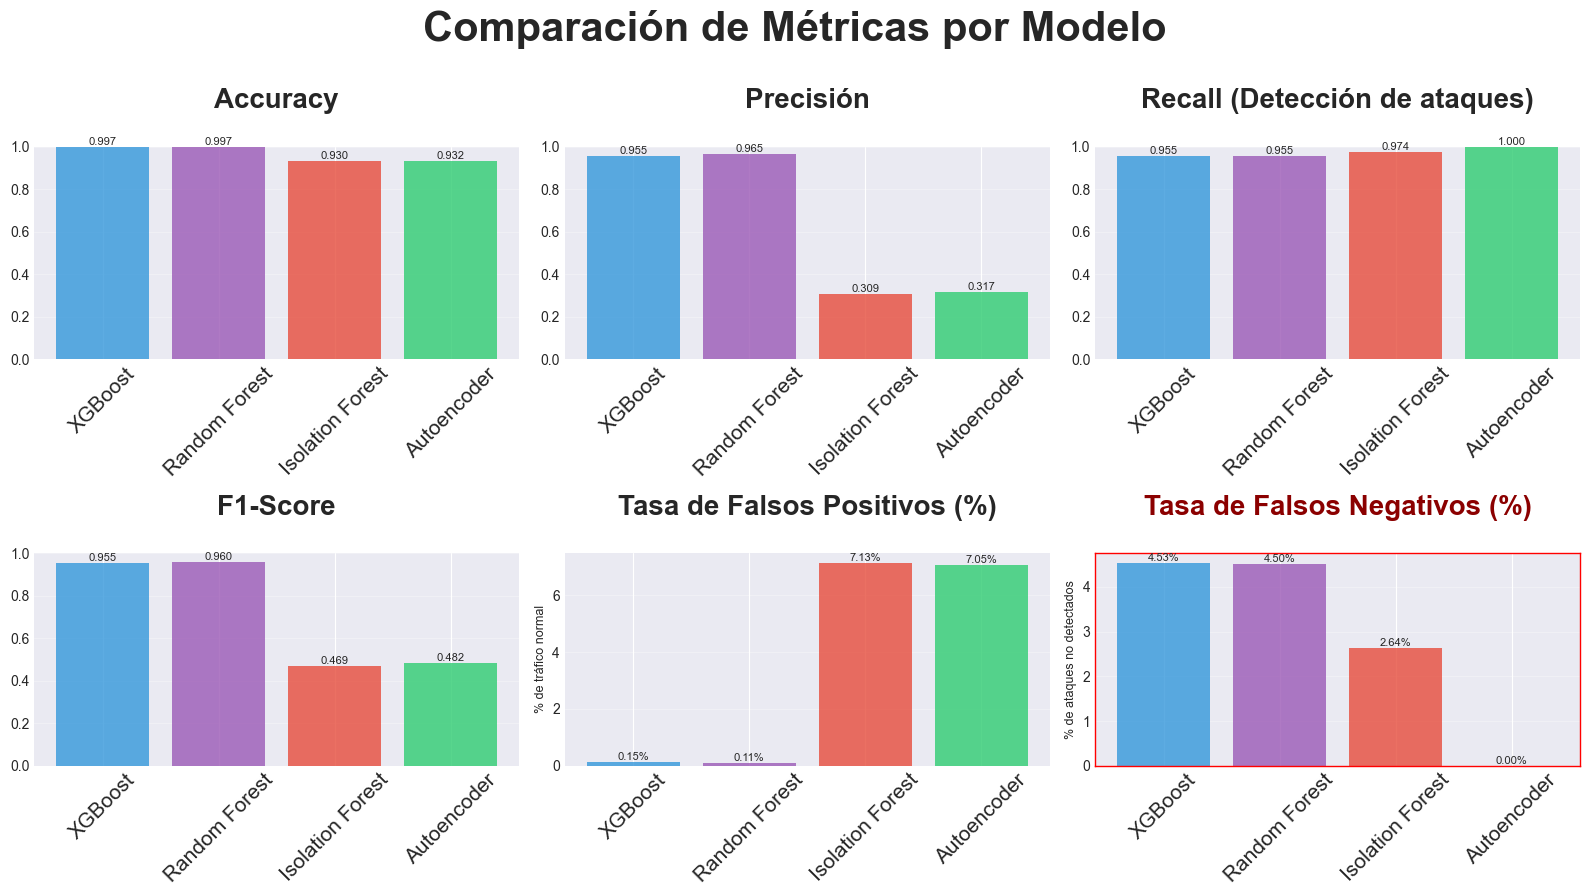

✓ Gráfico de comparación guardado en: all_models_metrics_comparison.png

RESUMEN DE MÉTRICAS - TODOS LOS MODELOS (CLASIFICACIÓN BINARIA)

XGBoost:
  Accuracy:  0.9971
  Precision: 0.9551
  Recall:    0.9547
  F1-Score:  0.9549
  FP Rate:   0.15%
  FN Rate:   4.53%

Random Forest:
  Accuracy:  0.9975
  Precision: 0.9646
  Recall:    0.9550
  F1-Score:  0.9598
  FP Rate:   0.11%
  FN Rate:   4.50%

Isolation Forest:
  Accuracy:  0.9301
  Precision: 0.3092
  Recall:    0.9736
  F1-Score:  0.4693
  FP Rate:   7.13%
  FN Rate:   2.64%

Autoencoder:
  Accuracy:  0.9317
  Precision: 0.3173
  Recall:    1.0000
  F1-Score:  0.4818
  FP Rate:   7.05%
  FN Rate:   0.00%


In [64]:
# Comparación visual de métricas para TODOS los modelos (supervisados + no supervisados)
if results:
    # Calcular todas las métricas en formato binario para TODOS los modelos
    all_metrics = {}
    
    # IMPORTANTE: Identificar qué índice corresponde a 'Normal'
    # LabelEncoder ordena alfabéticamente, por lo que 'Normal' puede no estar en índice 0
    normal_idx = list(le.classes_).index('Normal')
    
    for model_name, model_data in results.items():
        if model_data['type'] == 'binary':
            # Modelos no supervisados: ya están en binario
            y_pred = model_data['predictions']
            y_true = y_test_binary
        else:
            # Modelos supervisados: convertir multi-clase a binario
            y_pred_multiclass = model_data['predictions']
            y_true_multiclass = y_test_multi_encoded
            
            # Convertir a binario usando el índice correcto de 'Normal'
            y_pred = (y_pred_multiclass != normal_idx).astype(int)  # Normal=0, Ataque=1
            y_true = (y_true_multiclass != normal_idx).astype(int)
        
        # Matriz de confusión
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
        
        # Tasas de error
        total_normal = tn + fp
        total_attack = fn + tp
        fp_rate = (fp / total_normal * 100) if total_normal > 0 else 0
        fn_rate = (fn / total_attack * 100) if total_attack > 0 else 0
        
        # Métricas estándar
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
        
        all_metrics[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'fp_rate': fp_rate,
            'fn_rate': fn_rate
        }
    
    # Crear gráfico de 2x3 (6 subplots)
    fig, axes = plt.subplots(2, 3, figsize=(16, 9))
    fig.suptitle('Comparación de Métricas por Modelo', 
                 fontsize=30, fontweight='bold', y=0.99)

    models = list(all_metrics.keys())
    colors = ['#3498db', '#9b59b6', '#e74c3c', '#2ecc71'][:len(models)]

    # Función auxiliar para añadir valores
    def add_values(ax, bars, is_percentage=False):
        for bar in bars:
            height = bar.get_height()
            label = f'{height:.2f}%' if is_percentage else f'{height:.3f}'
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    label, ha='center', va='bottom', fontsize=8)

    # Accuracy -> proporción de predicciones correctas sobre el total de predicciones.
    accuracies = [all_metrics[m]['accuracy'] for m in models]
    bars = axes[0, 0].bar(models, accuracies, color=colors, alpha=0.8)
    axes[0, 0].set_title('Accuracy\n', fontweight='bold', fontsize=20)
    axes[0, 0].set_ylim([0, 1.0])
    axes[0, 0].tick_params(axis='x', rotation=45, labelsize=15)
    axes[0, 0].grid(axis='y', alpha=0.3)
    add_values(axes[0, 0], bars)

    # Precision -> proporción de verdaderos positivos entre todos los predichos como positivos.    precisions = [all_metrics[m]['precision'] for m in models]
    precisions = [all_metrics[m]['precision'] for m in models]
    bars = axes[0, 1].bar(models, precisions, color=colors, alpha=0.8)
    axes[0, 1].set_title('Precisión\n', fontweight='bold', fontsize=20)
    axes[0, 1].set_ylim([0, 1.0])
    axes[0, 1].tick_params(axis='x', rotation=45, labelsize=15)
    axes[0, 1].grid(axis='y', alpha=0.3)
    add_values(axes[0, 1], bars)

    # Recall -> proporción de verdaderos positivos entre todos los positivos reales. (MÁS IMPORTANTE para seguridad)
    recalls = [all_metrics[m]['recall'] for m in models]
    bars = axes[0, 2].bar(models, recalls, color=colors, alpha=0.8)
    axes[0, 2].set_title('Recall (Detección de ataques)\n', fontweight='bold', fontsize=20)
    axes[0, 2].set_ylim([0, 1.0])
    axes[0, 2].tick_params(axis='x', rotation=45, labelsize=15)
    axes[0, 2].grid(axis='y', alpha=0.3)
    add_values(axes[0, 2], bars)

    # F1-Score -> media armónica entre precisión y recall.
    f1s = [all_metrics[m]['f1'] for m in models]
    bars = axes[1, 0].bar(models, f1s, color=colors, alpha=0.8)
    axes[1, 0].set_title('F1-Score\n', fontweight='bold', fontsize=20)
    axes[1, 0].set_ylim([0, 1.0])
    axes[1, 0].tick_params(axis='x', rotation=45, labelsize=15)
    axes[1, 0].grid(axis='y', alpha=0.3)
    add_values(axes[1, 0], bars)

    # Tasa de Falsos Positivos (FP Rate)
    fp_rates = [all_metrics[m]['fp_rate'] for m in models]
    bars = axes[1, 1].bar(models, fp_rates, color=colors, alpha=0.8)
    axes[1, 1].set_title('Tasa de Falsos Positivos (%)\n', fontweight='bold', fontsize=20)
    axes[1, 1].set_ylabel('% de tráfico normal', fontsize=9)
    axes[1, 1].set_ylim(bottom=0)
    axes[1, 1].tick_params(axis='x', rotation=45, labelsize=15)
    axes[1, 1].grid(axis='y', alpha=0.3)
    add_values(axes[1, 1], bars, is_percentage=True)

    # Tasa de Falsos Negativos (FN Rate) - MÁS CRÍTICO
    fn_rates = [all_metrics[m]['fn_rate'] for m in models]
    bars = axes[1, 2].bar(models, fn_rates, color=colors, alpha=0.8)
    axes[1, 2].set_title('Tasa de Falsos Negativos (%)\n', fontweight='bold', 
                         color='darkred', fontsize=20)
    axes[1, 2].set_ylabel('% de ataques no detectados', fontsize=9)
    axes[1, 2].set_ylim(bottom=0)
    axes[1, 2].tick_params(axis='x', rotation=45, labelsize=15)
    axes[1, 2].grid(axis='y', alpha=0.3)
    
    # Resaltar el gráfico de FN con borde rojo
    for spine in axes[1, 2].spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(1)
    add_values(axes[1, 2], bars, is_percentage=True)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig('all_models_metrics_comparison.png', dpi=800, bbox_inches='tight')
    plt.show()

    print("✓ Gráfico de comparación guardado en: all_models_metrics_comparison.png")
    
    # Tabla resumen
    print("\n" + "="*80)
    print("RESUMEN DE MÉTRICAS - TODOS LOS MODELOS (CLASIFICACIÓN BINARIA)")
    print("="*80)
    for model_name, metrics in all_metrics.items():
        print(f"\n{model_name}:")
        print(f"  Accuracy:  {metrics['accuracy']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall:    {metrics['recall']:.4f}")
        print(f"  F1-Score:  {metrics['f1']:.4f}")
        print(f"  FP Rate:   {metrics['fp_rate']:.2f}%")
        print(f"  FN Rate:   {metrics['fn_rate']:.2f}%")
    print("="*80)
else:
    print("No hay modelos para comparar")

## 7. Resumen Final

In [60]:
print("=" * 80)
print("RESUMEN DEL EXPERIMENTO")
print("=" * 80)

print(f"\n DATASET: UNSW-NB15")
print(f"   └─ Muestras de entrenamiento: {TRAIN_SIZE:,}")
print(f"   └─ Muestras de prueba:        {TEST_SIZE:,}")
print(f"   └─ Características (features): {X_train.shape[1]}")
print(f"   └─ Tipos de ataque:           {len(le.classes_)}")

print(f"\n MODELOS ENTRENADOS: {len(results)}")
for model_name in results.keys():
    model_type = results[model_name]['type']
    tipo_str = "Supervisado - Multi-clase" if model_type == 'multiclass' else "No supervisado - Binario"
    print(f"   ✓ {model_name} ({tipo_str})")

if results:
    # Encontrar mejor modelo
    best_model = max(results.items(), 
                     key=lambda x: accuracy_score(
                         y_test_multi_encoded if x[1]['type'] == 'multiclass' else y_test_binary,
                         x[1]['predictions']
                     ))
    best_acc = accuracy_score(
        y_test_multi_encoded if best_model[1]['type'] == 'multiclass' else y_test_binary,
        best_model[1]['predictions']
    )
    
    print(f"\n MEJOR MODELO (por Precisión):")
    print(f"   → {best_model[0]}")
    print(f"   → Precision: {best_acc:.4f} ({best_acc*100:.2f}%)")

    # Estadísticas por tipo de modelo
    supervised = [k for k, v in results.items() if v['type'] == 'multiclass']
    unsupervised = [k for k, v in results.items() if v['type'] == 'binary']
    
    print(f"\n DISTRIBUCIÓN DE MODELOS:")
    print(f"   - Supervisados (multi-clase):  {len(supervised)}")
    print(f"   - No supervisados (anomalías): {len(unsupervised)}")
else:
    print("\n  No se entrenaron modelos")

print("\n" + "=" * 80)
print(" EXPERIMENTO COMPLETADO EXITOSAMENTE")
print("=" * 80)

RESUMEN DEL EXPERIMENTO

 DATASET: UNSW-NB15
   └─ Muestras de entrenamiento: 350,000
   └─ Muestras de prueba:        350,000
   └─ Características (features): 43
   └─ Tipos de ataque:           10

 MODELOS ENTRENADOS: 4
   ✓ XGBoost (Supervisado - Multi-clase)
   ✓ Random Forest (Supervisado - Multi-clase)
   ✓ Isolation Forest (No supervisado - Binario)
   ✓ Autoencoder (No supervisado - Binario)

 MEJOR MODELO (por Precisión):
   → Random Forest
   → Precision: 0.9914 (99.14%)

 DISTRIBUCIÓN DE MODELOS:
   - Supervisados (multi-clase):  2
   - No supervisados (anomalías): 2

 EXPERIMENTO COMPLETADO EXITOSAMENTE
